In [187]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [188]:
# Set-up DataFrame for NLP
subreddits = pd.read_csv('../data/subreddits_clean.csv')

In [189]:
#Set-up X- and y-variables
# NOTE: cvec needs a vector(Series), not a matrix(DataFrame)
X = subreddits['submission_text']
y = subreddits['subreddit']

In [234]:
# Split the data into the training and testing sets.
Xa_train, Xa_test, ya_train, ya_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=86)

In [190]:
# To streamline process of stop word identification a random subset of the data, more manageable in size, is introduced here
a = list(np.sort(np.random.choice(list(subreddits.index), size=20000)))
subreddits_a = subreddits.loc[a,['submission_text','subreddit']]

Xa = subreddits_a['submission_text']
ya = subreddits_a['subreddit']

# Split the data into the training and testing sets.
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,
                                                    ya,
                                                    stratify=ya,
                                                    random_state=86)

## Model Preparation

##### Establish a baseline accuracy (predicting the plurality class)

In [236]:
# The Null Model is about 50/50
ya_train.value_counts(normalize=True)

1    0.507354
0    0.492646
Name: subreddit, dtype: float64

In [237]:
# Pipeline 1 Set-Up: cvec

# Stage 1. CountVectorizer (transformer)
# Stage 2. Multinomial Naive Bayes (estimator)
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(max_features=500,
                             stop_words = my_stop_words,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0,
                             min_df=2)),
    ('nb', MultinomialNB())
])

# Pipeline 2 Set-Up: tvec
# Stage 1. TF-IDF (transformer)
# Stage 2. Multinomial Naive Bayes (estimator)
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(max_features=500,
                             stop_words = my_stop_words,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0,
                             min_df=2)),
    ('nb', MultinomialNB())
])

# Estimate Multinomial Naive Bayes performance, with each vectorizer, on unseen data
cvec_cv_score = cross_val_score(pipe_cvec, Xa_train, ya_train, cv=5, n_jobs=-2, verbose=1).mean() 
tvec_cv_score = cross_val_score(pipe_tvec, Xa_train, ya_train, cv=5, n_jobs=-2, verbose=1).mean()

# Display cross-val scores for easy comparison
print(f'Cross-Val Scores:\n\tCount-V = {round(cvec_cv_score*100,3)}%\n\tTF-IDF  = {round(tvec_cv_score*100,3)}%')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:   32.1s remaining:   48.2s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   32.7s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:   34.6s remaining:   51.9s


Cross-Val Scores:
	Count-V = 70.654%
	TF-IDF  = 70.341%


[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   35.8s finished


### RUN ONLY FOR SCORE:

In [238]:
# Fit each pipeline with default parameters
pipe_cvec.fit(Xa_train, ya_train)
pipe_tvec.fit(Xa_train, ya_train)

# Training scores
cvec_train_score = pipe_cvec.score(Xa_train, ya_train)
tvec_train_score = pipe_tvec.score(Xa_train, ya_train)

# Test scores
cvec_test_score = pipe_cvec.score(Xa_test, ya_test)
tvec_test_score = pipe_tvec.score(Xa_test, ya_test)

# Display scores for easy comparison of Vectorizors
print(f'Training Scores:\n\tCount-V = {round(cvec_train_score*100,3)}%\n\tTF-IDF  = {round(tvec_train_score*100,3)}%')
print(f'Test Scores:\n\tCount-V = {round(cvec_test_score*100,3)}%\n\tTF-IDF  = {round(tvec_test_score*100,3)}%')

Training Scores:
	Count-V = 70.742%
	TF-IDF  = 70.425%
Test Scores:
	Count-V = 71.085%
	TF-IDF  = 70.607%


In [239]:
## Dvelopment of unique word-stop bank

# Instantiate CVEC Transformer
cvec_trans = CountVectorizer(max_features=500,
                             stop_words = my_stop_words,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0,
                             min_df=2)

# Instantiate TVEC Transformer
tvec_trans = TfidfVectorizer(max_features=500,
                             stop_words = my_stop_words,
                             ngram_range=(1,2),
                             binary=True,
                             max_df=1.0,
                             min_df=2)

# Transform the train corpora to obtain SciPy sparse matrices
X_train_cvec = cvec_trans.fit_transform(Xa_train)
X_train_tvec = tvec_trans.fit_transform(Xa_train)

# Convert train-data to Pandas DataFrame for easy visualization
X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), 
                              columns=cvec_trans.get_feature_names())

X_train_tvec_df = pd.DataFrame(X_train_tvec.todense(), 
                              columns=tvec_trans.get_feature_names())

# Verify dimensions and shape
print(X_train_cvec.shape, type(X_train_cvec))
print(X_train_tvec.shape, type(X_train_tvec))

(125100, 500) <class 'scipy.sparse.csr.csr_matrix'>
(125100, 500) <class 'scipy.sparse.csr.csr_matrix'>


##### STOP WORDS

In [280]:
X_train_cvec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125100 entries, 0 to 125099
Columns: 500 entries, 10 to young
dtypes: int64(500)
memory usage: 477.2 MB


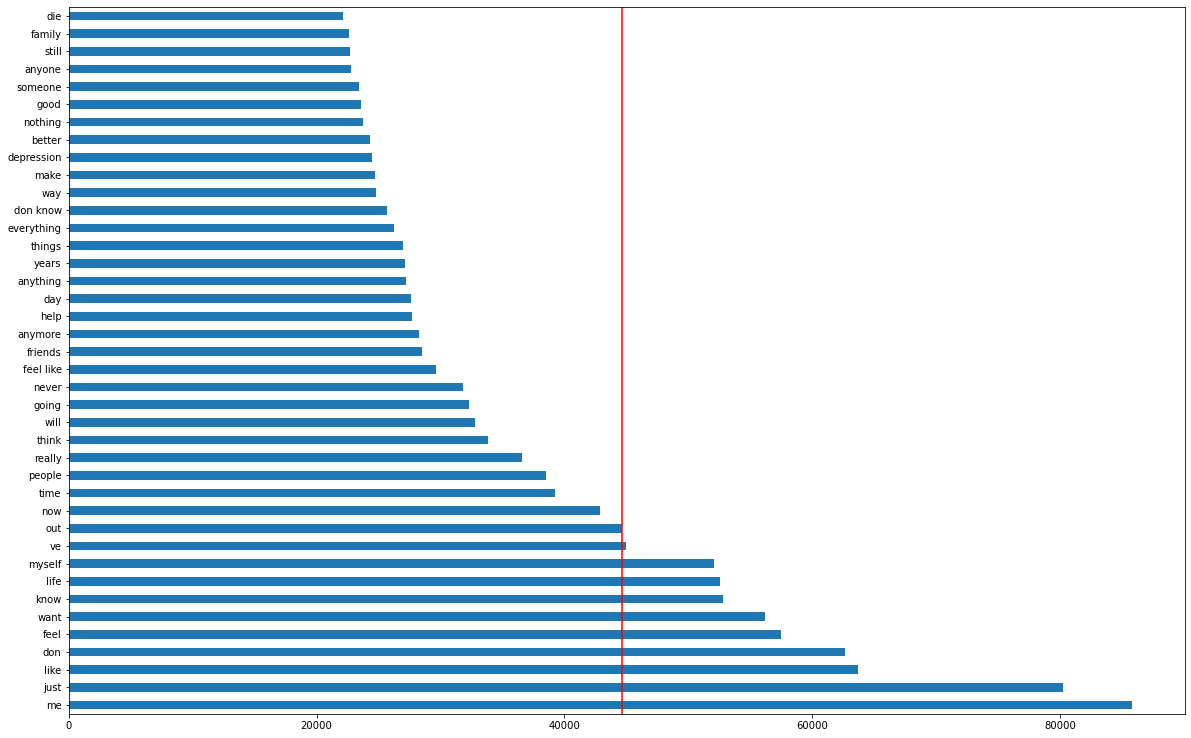

In [242]:
# plot top occuring words
X_train_cvec_df.sum().sort_values(ascending=False).head(40).plot(kind='barh',figsize=(20,13));
plt.axvline(x=X_train_cvec_df.sum().sort_values().quantile(q=0.98),c='r');
# sklearn's stopwords
#print(CountVectorizer(stop_words = 'english').get_stop_words())

In [254]:
print(X_train_cvec_df.shape)
X_train_cvec_df.sum().sort_values(ascending=False)[10:20]

(125100, 500)


out          44666
now          42902
time         39230
people       38542
really       36549
think        33838
will         32783
going        32345
never        31835
feel like    29656
dtype: int64

In [253]:
print(X_train_tvec_df.shape)
X_train_tvec_df.sum().sort_values(ascending=False)[10:20]

(125100, 500)


out          4274.318565
now          4166.365573
people       4058.072520
time         3915.634586
really       3868.861470
will         3743.363912
think        3717.970692
going        3623.708671
anymore      3487.452941
feel like    3449.263547
dtype: float64

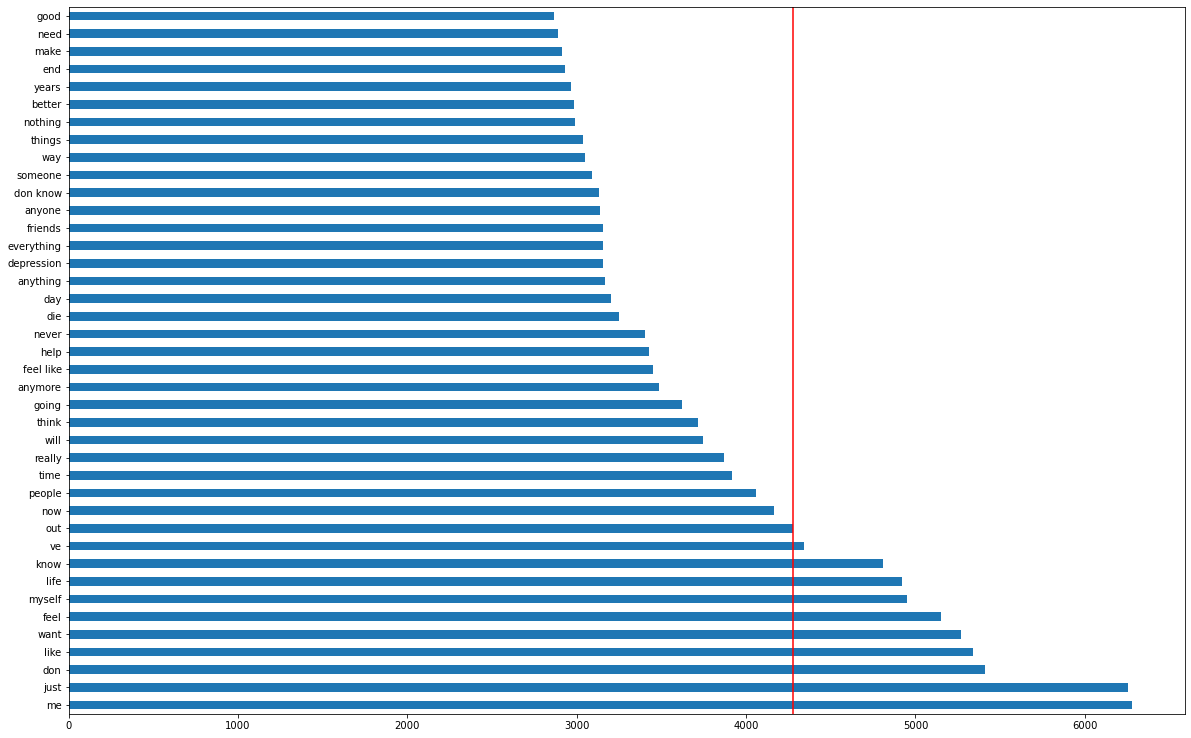

In [243]:
# plot top occuring words
X_train_tvec_df.sum().sort_values(ascending=False).head(40).plot(kind='barh',figsize=(20,13));
plt.axvline(x=X_train_tvec_df.sum().sort_values().quantile(q=0.98),c='r');
# sklearn's stopwords
#print(CountVectorizer(stop_words = 'english').get_stop_words())

### Fig. 01  
***Notice the 97th quantile (red line) is right on the boundary of introducing 'want to', the 2-gram with the highest document frequency. I like this to be my first guess for a cut-off max_df because n-grams are one of the few ways that this model will account for the contextual meaning typically present in language. There are uninteresting tokens, both more and less frequent, but tokens more frequently occurring in the data will be designated as Stop-Words for initial model tuning.***

In [ ]:
# Verify No. of columns are max_features
print(X_train.shape)

In [ ]:
# Notice the 97th quantile is right on the boundary of introducing the most frequent 2-gram.
print(X_train_df.sum().sort_values().quantile(q=0.964))
X_train_df.sum().sort_values()[962:965]

In [ ]:
# % of documents in X_train with 2-gram 'want to' 
round(X_train_df.sum().sort_values()[963:964]/X_train.shape[0],3)

In [ ]:
# Inspect tokens in corpus
cvec.get_feature_names()[800:900];

In [ ]:
len(cvec.vocabulary_)

In [ ]:
cvec.stop_words_;

In [ ]:
cvec.vocabulary_;

In [ ]:
cvec.get_feature_names();

In [ ]:
# For my stop words I took the 10,000 most common words and found that 255 of them were in the CountVectorizer's list of 318 'english' stop-words.
# I then went through those 255 and removed theh ones that did not seem approrpriate to keep. That list is my stop_words_removed.
stops_cvec = list(CountVectorizer(stop_words = 'english').get_stop_words())
print(f'No. of Stop Words in C-Vec: {len(stops_cvec)}')

tops = X_train_cvec_df.sum().sort_values(ascending=False)[:10000].index.tolist()
print(f'No. of Stop Words chosen: {len(tops)}')

In [271]:
X_train_cvec_df[X_train_cvec_df.isnull()].sum()

10            0.0
20            0.0
able          0.0
absolutely    0.0
actually      0.0
             ... 
year          0.0
years         0.0
years ago     0.0
years old     0.0
young         0.0
Length: 500, dtype: float64

In [338]:
# Make a DataFrame to ID top words in each of the subreddits
sub = pd.DataFrame(ya_train).reset_index()
words_and_subreddits = pd.concat( [X_train_cvec_df, sub],axis=1)
words_and_subreddits.drop(columns='index',inplace=True)

In [369]:
# Look at the top 500 tokens in each subreddit
suicide_top500 = list(words_and_subreddits[words_and_subreddits['subreddit']==1].sum().sort_values(ascending=False)[:500].index)
depression_top500 = list(words_and_subreddits[words_and_subreddits['subreddit']==0].sum().sort_values(ascending=False)[:500].index)

both = []
suicide_only = []
depression_only =[]
for token in suicide_top500:
    
    if token in depression_top500:
        both.append(token)
    else:
        suicide_only.append(token)
for token in depression_top500:
    if token not in suicide_top500:
        depression_only.append(token)
        print(token)
print(f' Both: {len(both)}, Suicide Only: {len(suicide_only)}, Depression Only: {len(depression_only)}')
print(suicide_only, depression_only)


games
 Both: 499, Suicide Only: 1, Depression Only: 1
['subreddit'] ['games']


In [ ]:
text_and_subredditwords = []
maybes =[]
for word in tops:
    if word in stops:
        my_stop_words.append(word)
    else:
        maybes.append(word)
len(my_stop_words)

In [227]:
for word in my_stop_words_removed:
    my_stop_words.remove(word)

ValueError: list.remove(x): x not in list

In [281]:
list(my_stop_words);

In [283]:
my_stop_words_removed;

In [ ]:
print(len(my_stop_words))

In [ ]:
%store -r my_stop_words
len(my_stop_words)

In [ ]:

for word in ['just', 'like', 'don','ve', 'things', 'in my', 'of my']:
    my_stop_words.append(word)
%store my_stop_words

In [ ]:
# STOP WORDS

# Convert training data to dataframe
X2_train_df = pd.DataFrame(X2_train.todense(), 
                          columns=cvec2.get_feature_names())

# plot top occuring words
X2_train_df.sum().sort_values(ascending=False).head(40).plot(kind='barh',figsize=(10,13));
plt.axvline(x=X2_train_df.sum().sort_values().quantile(q=0.964),c='r');
# Let's look at sklearn's stopwords.
#print(CountVectorizer(stop_words = 'english').get_stop_words())